In [92]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = "svg"

from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, accuracy_score, RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier

from typing import Tuple, Optional, Generator, Any, Union

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import getTEvents, get_dollar_bars, get_returns, get_daily_vol, add_vertical_barrier, \
                      get_events_tripple_barrier, get_bins,get_bollinger_bands_df, \
                      get_upside_bars_bb, get_downside_bars_bb

## Auxilary Functions

In [93]:
def get_train_times(t1: pd.Series, testTimes: pd.Series) -> pd.Series:
    '''
    Given test times, find the times of the training observations
    
        Parameters:
            t1 (pd.Series): start timestamps (t1.index) and end timestamps (t1.values) of observations
            testTimes (pd.Series): start and end timestamps of testing observations (structure similar to t1)
            
        Returns:
            train (pd.Series): series with purged observations from the training set
    '''
    train = t1.copy(deep=True)
    for start, end in testTimes.iteritems():
        df0 = train[(start <= train.index) & (train.index <= end)].index    # train starts within test
        df1 = train[(start <= train) & (train <= end)].index                # train ends within test
        df2 = train[(train.index <= start) & (end <= train)].index          # train envelops test
        train = train.drop(df0.union(df1).union(df2))
    return train

In [94]:
def get_embargo_times(times: np.ndarray, pctEmbargo: float = 0.0) -> pd.Series:
    '''
    Get embargo time for each bar
    
        Parameters:
            times (np.ndarray): timestamps of bars
            pctEmbargo (float): share of observations to drop after test
            
        Returns:
            mbrg (pd.Series): series with bar timestamps (mbrg.index) and embargo time for each bar (mbrg.values)
    '''
    step = int(times.shape[0] * pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

In [95]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals.
    The train is purged of observations overlapping test-label intervals.
    Test set is assumed contiguous (shuffle=False), without training samples in between.
    '''
    
    def __init__(
        self, n_splits: int = 3, t1: Optional[pd.Series] = None, pctEmbargo: float = 0.0
    ) -> None:
        if not isinstance(t1, pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo
        
    def split(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None, groups: Optional[np.ndarray] = None
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i, j in test_starts:
            t0 = self.t1.index[i]    # start of test set
            test_indices = indices[i: j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1 <= t0].index)
            if maxT1Idx < X.shape[0]:    # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx + mbrg:]))
            yield train_indices, test_indices

In [96]:
# necessary to avoid bugs with 'classes_' and 'sample_weight' in sklearn implementation
def cvScore(
    clf: Any, X: pd.DataFrame, y: pd.Series, sample_weight: pd.Series, scoring: str ='neg_log_loss',
    t1: Optional[pd.Series] = None, cv: Optional[int] = None,
    cvGen: Optional[PurgedKFold] = None, pctEmbargo: Optional[float] = None
) -> np.ndarray:
    '''
    Calculating cross-validation score.
    
        Parameters:
            clf (Any): model we want to fit
            X (pd.DataFrame): feature matrix
            y (pd.Series): labels
            sample_weight (pd.Series): sample weights
            scoring (str): score we want to compute
            t1 (pd.Series): start timestamps (t1.index) and end timestamps (t1.values) of observations
            cv (int): number of splits
            cvGen (PurgedKFold): object of PurgedKFold class to make splitting
            pctEmbargo (float): share of observations to drop after test
            
        Returns:
            score (np.ndarray): score for each cross-validation split
    '''
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('wrong scoring method')
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)    # purged
    score = []
    for train, test in cvGen.split(X=X):
        fit = clf.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight.iloc[train].values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X.iloc[test, :])
            score_ = -log_loss(y.iloc[test], prob, sample_weight=sample_weight.iloc[test].values, labels=clf.classes_)
        else:
            pred = fit.predict(X.iloc[test, :])
            score_ = accuracy_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values)
        score.append(score_)
    return np.array(score)

## Exercises

Here I upload the data and construct the same dataset that appeared in `Chapter 3`. I will use it for the following exercises.

In [97]:
data = pd.read_csv('sp10-19.csv')

# copied from Chapter 3
dollar_bars = get_dollar_bars(data['price'].values, data['volume'].values, data['datetime'].values, 50000)
dollar_bars_df = pd.DataFrame(data=dollar_bars[:, 1:], index=dollar_bars[:, 0],
                           columns=['open', 'high', 'low', 'close', 'volume'])
dollar_bars_df = dollar_bars_df[~dollar_bars_df.index.duplicated(keep='first')]
mean_std = get_daily_vol(dollar_bars_df['close']).mean()
dollar_ret = get_returns(dollar_bars)
tEvents = getTEvents(dollar_ret, h=mean_std)
t1 = add_vertical_barrier(dollar_bars_df['close'], tEvents, numDays=1)


ma, b_upper, b_lower = get_bollinger_bands_df(dollar_bars_df, 1)
dollar_bars_df_bb = dollar_bars_df.copy(deep=True)
dollar_bars_df_bb['ma'], dollar_bars_df_bb['b_upper'], dollar_bars_df_bb['b_lower'] = ma, b_upper, b_lower
up_timestamps, down_timestamps = get_upside_bars_bb(dollar_bars_df_bb), get_downside_bars_bb(dollar_bars_df_bb)


side_index = up_timestamps.index.union(down_timestamps.index)
side_data = []
for idx in side_index:
    if idx in up_timestamps.index:
        side_data.append(1)
    else:
        side_data.append(-1)
side = pd.Series(data=side_data, index=side_index)


events_bb = get_events_tripple_barrier(close=dollar_bars_df['close'], tEvents=tEvents, pt_sl=[0, 2],
                                       trgt=get_daily_vol(dollar_bars_df['close']), minRet=0.007,
                                       numThreads=1, t1=t1, side=side)
events_bb = events_bb.dropna()


bins_bb = get_bins(close=dollar_bars_df_bb['close'], events=events_bb, t1=t1)

In [98]:
X = pd.DataFrame(
    {'vol': get_daily_vol(dollar_bars_df['close']),
     'autocorr': dollar_ret.rolling(20, min_periods=1).corr(dollar_ret.shift(1)).dropna(),
     'side': events_bb['side']}
).dropna()
X = X[~X.index.duplicated(keep='first')]
y = bins_bb['bin'].astype(int)
X.head()

,vol,autocorr,side
2010-01-28 22:25:49,0.013559,0.022432,-1.0
2010-02-07 17:19:56,0.009584,-0.177135,-1.0
2010-05-06 15:31:04,0.009708,0.304007,-1.0
2010-05-14 00:53:31,0.010092,-0.116137,-1.0
2010-05-20 19:41:22,0.010745,-0.081836,-1.0


Now we are ready to move to the exercises.

### 1. Cross-Validation with and without Shuffling

Here we apply simple CV (not purged) and compare results with and without shuffling data.

In [99]:
def plot_cv_results(cv: Union[StratifiedKFold, PurgedKFold], clf: Any, X: pd.DataFrame, y: pd.Series) -> None:
    '''
    Plots ROC curve for each iteration of cross-validation together with the mean curve
    and print cv accuracy.
    Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval
    '''
    for scoring in ['accuracy', 'precision', 'recall']:
        score = cross_val_score(estimator=clf, X=X, y=y, scoring=scoring, cv=cv, n_jobs=-1)
        print(f'CV mean {scoring}: {np.mean(score)}')
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(np.array(X)[train], np.array(y)[train])
        viz = RocCurveDisplay.from_estimator(clf, np.array(X)[test], np.array(y)[test], name="ROC fold {}".format(i),
                                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.show()

CV mean accuracy: 0.5795286195286196
CV mean precision: 0.6181440781440781
CV mean recall: 0.5333333333333334


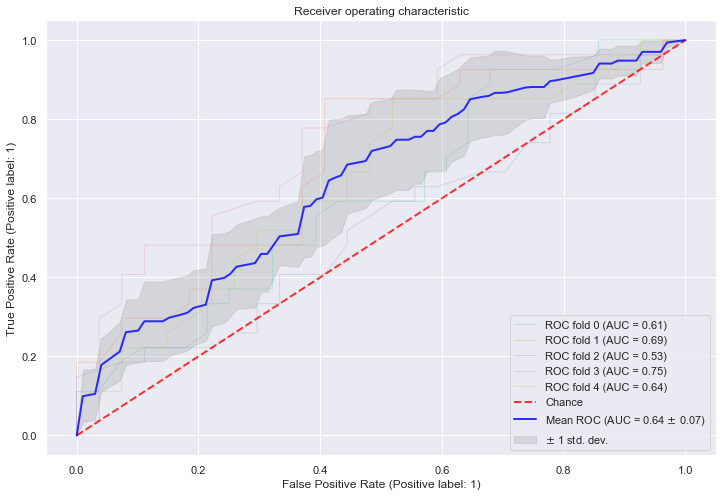

In [100]:
# 5 splits instead of 10
cv = StratifiedKFold(n_splits=5, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1)
plot_cv_results(cv, clf, X, y)

CV mean accuracy: 0.5756228956228956
CV mean precision: 0.5987000259268862
CV mean recall: 0.5555555555555556


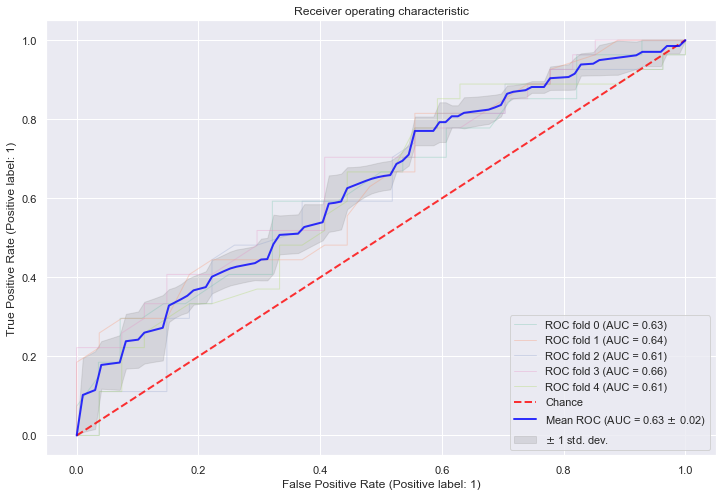

In [101]:
# 5 splits instead of 10
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1)
plot_cv_results(cv, clf, X, y)

We can see that shuffling increases model's quality a little. The difference is not significant as our dataset has very few observations and only 3 features. In general, shuffling would increase the CV score (in other words, the classifier would overfit) because shuffling puts correlated samples into training set. There is also information leakage - in financial datasets samples are not IID and have memory.

### 2. Purged Cross-Validation

Here we use the same function as in the previous exercises but with purged CV and embargo.

CV mean accuracy: 0.5792592592592593
CV mean precision: 0.5734080734080733
CV mean recall: 0.5560637254901961


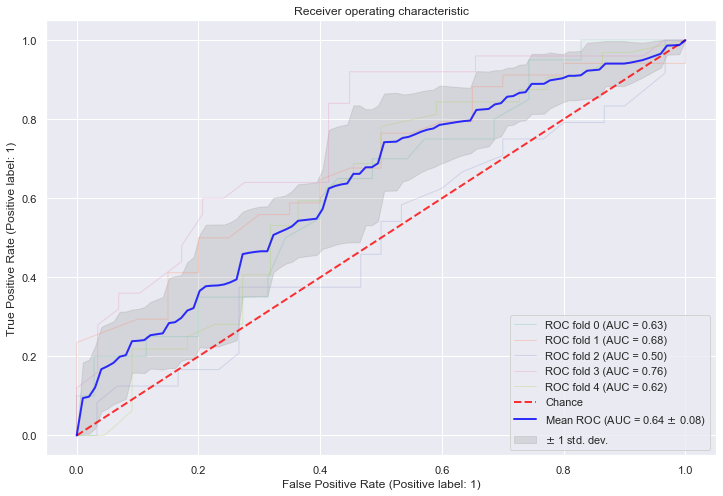

In [102]:
# 5 splits instead of 10
cv = PurgedKFold(n_splits=5, t1=t1[X.index], pctEmbargo=0.05)
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
plot_cv_results(cv, clf, X, y)

The quality is again a bit lower that when using the default cross-validation due to the fact that purged CV eliminates overlapping time intervals between train and test samples. This reduces leakage even more, and so we can consider the result of purged CV to be more correct than that of regular CV.